# Capstone Project: Prime coffee shop location in London

## 1. Introduction

**The Problem: *Where should I open a new coffee shop in London?***

If I were interested in opening a new coffee shop in London - a bustling city with plenty of independent cafes and restaurants scattered over many neighbourhoods - where would the best location be? In this project, I'll answer this question using location data from the Foursquare API.  

In order to find the perfect spot, we need to consider criteria that might be markers of a "good" location. One clear marker could be locations that have few existing coffee shops, which would minimise competition. However, locations might not have coffee shops for good reasons (lack of demand/passing trade, etc.). So we should probably consider some other factors too. Another marker of a good location could be proximity to universities — students like caffeine! Finally, we would want a good amount of passing trade, so proximity to retail and other attractions, such as museums and theaters, should also be considered. All in all, the following criteria should help prospective coffee shop owners to choose a good location:

1. Few existing coffee shops (low competition)
2. Near students (caffeine demand)
3. Near retail, museums or other attractions (passing trade)

In this project, I will highlight the best possible neighbourhoods by exploring and clustering locations within the central London area, using the above criteria to select a group of candidate locations.

## 2. Data

The data used for this project comes from Wikipedia (London locations) and the Foursquare API (information on surrounding venues). Together, the data include London neighbourhoods, with their latitude and longitude, as well as information about the number of coffee shops, universities, shops, and attractions for each location collected using Foursquare. 

- London locations are scraped from this Wikipedia page: https://en.wikipedia.org/wiki/List_of_areas_of_London. The data will be filtered to find all of the neighbourhoods within the central London postal area.
- I'll use the Foursquare API to run a series of searches for each neighbourhood, collecting the number of venues within different search categories (coffee, universities, retail, entertainment) per location.

The Foursquare data will be used to cluster my London locations according to their venue distribution (i.e. the frequency of coffee shops, universities, retail, and entertainment venues that exist in each area).

## 3. Methodology

Let's start by importing some useful packages:

In [1]:
# libraries
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from geopy.geocoders import Nominatim
import geocoder
import folium
import requests

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

# my foursquare credentials (saved as .py file for privacy)
import foursquare_id as login

### 3.1. London neighbourhoods

First, I need to get the London locations I'm interested in as well as their longitude and latitude. I'm going to focus on postal codes in central London.

#### *Postal codes*

I'll use pandas to import the London areas from Wikipedia (see **Data**)

In [2]:
locations = pd.read_html("https://en.wikipedia.org/wiki/List_of_areas_of_London")[1]
locations.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [3]:
### print('Size of London locations dataframe:')
locations.shape

(532, 6)

Now, I need to clean up the location data. There are a lot of locations in the above dataframe, so let's restrict our locations to those within the central London postal area. 
  
First, I'm going to make sure that each row of the dataframe has a unique postal code:

In [4]:
locations = locations.drop(['Postcode\xa0district','Post town','London\xa0borough','Dial\xa0code','OS grid ref'], axis=1).join(locations['Postcode\xa0district'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))
locations.head(5)

,Location,Postcode
0,Abbey Wood,SE2
1,Acton,W3
1,Acton,W4
2,Addington,CR0
3,Addiscombe,CR0


Next, I'm going to filter by those locations within the central London postal area:

In [5]:
# work out which postcodes are within central london
central_codes = ['WC1', 'WC2', 'EC1', 'EC2', 'EC3', 'EC4', 'E1', 'E2', 'W1', 'W2', 'NW1', 'N1', 'SW1', 'SE1']
postcodes = locations['Postcode']
locations_central = locations.loc[np.array(postcodes.str.fullmatch('|'.join(central_codes))).tolist(),].reset_index(drop=True)

# remove Chinatown (after inspection, it is consistently plotted in the wrong location from geocoder)
locations_central = locations_central[locations_central['Location'] != "Chinatown"]

# check that every row contains a unique neighbourhood name:
if len(locations_central['Location'].unique()) != len(locations_central.index):
    print('Duplicate locations found')

# show all of my locations
print('Found',len(locations_central.index),'central London locations')
locations_central.head(10)

Found 56 central London locations


,Location,Postcode
0,Aldgate,EC3
1,Aldwych,WC2
2,Angel,EC1
3,Bankside,SE1
4,Barbican,EC1
5,Barnsbury,N1
6,Bayswater,W2
7,Belgravia,SW1
8,Bermondsey,SE1
9,Bethnal Green,E2


#### *Longitude and Latitude*

Now that I have my neighbourhoods, I'll fetch the longtitude and latutude of each London location.  

To do this, I'll use the geocoder package. Here's a function to get coordinates:

In [6]:
def get_latlng(loc,pc):
    
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, {}, United Kingdom'.format(loc,pc))
        lat_lng_coords = g.latlng
        lat_lng_coords.append(loc) #add location to output
    return lat_lng_coords

Let's check that this function works as expected -- to do so, I'll use reverse coding. So, if provided with the coordinates returned from the above function, does geocoder give me back the correct address?

In [8]:
# take as example the location and postal code from the first row of the dataframe
example_coords = get_latlng('Aldgate','EC3')
print('Reverse coding: Aldgate, EC3; coordinates = {}'.format(example_coords[0:2]))

# reverse code to get the address
geocoder.geocodefarm(example_coords[0:2], method='reverse')

Reverse coding: Aldgate, EC3; coordinates = [51.51331168804641, -0.07776472785585485]


<[OK] Geocodefarm - Reverse [Leadenhall Street, Aldgate, EC3A 3DE, United Kingdom]>

Great, so geocoder seems to work fine.

I'm applying this function to all of my London postcodes, ending up with a dataframe. Each row contains a postcode with it's longitude and latitude values. Here are the top 10 rows of the resulting dataframe:  

In [8]:
coords = pd.DataFrame([get_latlng(i,j) for i, j in zip(locations_central['Location'],locations_central['Postcode'])])
coords.columns = ["Latitude","Longitude","Location"]
coords.head(10)

,Latitude,Longitude,Location
0,51.513312,-0.077765,Aldgate
1,51.512653,-0.118607,Aldwych
2,51.524730,-0.087540,Angel
3,51.508164,-0.095216,Bankside
4,51.520070,-0.093530,Barbican
5,51.536489,-0.110907,Barnsbury
6,51.510480,-0.184260,Bayswater
7,51.497050,-0.152750,Belgravia
8,51.497900,-0.081440,Bermondsey
9,51.524190,-0.059440,Bethnal Green


Here's a map of all of my locations, generated using folium.
To create the map, I'm using the geopy package to fetch the longtitude and latitude of London:

In [9]:
address = 'Chancery Lane, London, United Kingdom'
geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
lon_lat = location.latitude
lon_lng = location.longitude
print('The coordinates of London are {}, {}.'.format(lon_lat, lon_lng))

The coordinates of London are 51.5181074, -0.1123604.


In [10]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[lon_lat, lon_lng], zoom_start=13)

# add markers to map
for lat, lng, label in zip(coords['Latitude'], coords['Longitude'], coords['Location']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='#4e54c8',
        fill=True,
        fill_color='#8f94fb',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

### 3.2. Foursquare data

Now that I have my London locations, I'll set up the Foursquare API to obtain data about venues within each neighbourhood. To do this, I need to load in my credentials and specify relevant search terms and parameters. I'm limiting each search result to a maximum of 50 venues to limit API calls.  

I'm using a radius of 500m for coffee shps, due to number, but a radius of 1km for other venue categories.

Note that, for privacy, my foursquare credentials were loaded in from file *foursquare_id.py* as *login* at the beginning of the *Data* section.

In [11]:
# stored in file foursquare_id.py (gitignored) to avoid showing here
CLIENT_ID = login.foursquare['accessID'] # Foursquare ID
CLIENT_SECRET = login.foursquare['secretID'] # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # to limit my search results

Here are the search terms that I'll use within Foursquare to gather information about my London locations:

In [12]:
QUERY_list = ["Coffee","Colleges","Shopping","Fun"]

Now I'm looping through each search term to return the number of venues within each category and location:

In [13]:
venues_list=[]
for query in QUERY_list:
    if query == "Coffee":
        RADIUS = 500
    else: 
        RADIUS = 1000
        
    for name, lat, lng in zip(coords['Location'], coords['Latitude'], coords['Longitude']):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                RADIUS, 
                LIMIT,
                query)
        results = requests.get(url).json()["response"]['venues']
        venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        query,
                        len(results))])


In [14]:
# convert to data frame
nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['Location', 
                  'Latitude', 
                  'Longitude', 
                  'Category', 
                  'Count']

# spread so that categories are unique columns
nearby_venues = nearby_venues.pivot(index=["Location","Latitude","Longitude"],columns="Category",values="Count").reset_index()
nearby_venues.head(15)

Category,Location,Latitude,Longitude,Coffee,Colleges,Fun,Shopping
0,Aldgate,51.513312,-0.077765,36,0,12,0
1,Aldwych,51.512653,-0.118607,40,6,25,5
2,Angel,51.524730,-0.087540,35,1,20,1
3,Bankside,51.508164,-0.095216,27,2,9,2
4,Barbican,51.520070,-0.093530,27,1,17,3
5,Barnsbury,51.536489,-0.110907,6,0,8,4
6,Bayswater,51.510480,-0.184260,4,1,3,0
7,Belgravia,51.497050,-0.152750,8,0,7,4
8,Bermondsey,51.497900,-0.081440,8,1,2,0
9,Bethnal Green,51.524190,-0.059440,10,0,4,1


I am going to normalize each column (coffee, fun, shopping, colleges) across all locations to make the scales comparable (between 0 and 1):

In [15]:
def norm(x):
    n = (x - np.min(x))/(np.max(x) - np.min(x))
    return n

In [16]:
for c in QUERY_list:
    nearby_venues[c] = norm(np.array(nearby_venues[c]))

nearby_venues.head(15)

Category,Location,Latitude,Longitude,Coffee,Colleges,Fun,Shopping
0,Aldgate,51.513312,-0.077765,0.714286,0.000000,0.461538,0.000
1,Aldwych,51.512653,-0.118607,0.795918,1.000000,0.961538,0.625
2,Angel,51.524730,-0.087540,0.693878,0.166667,0.769231,0.125
3,Bankside,51.508164,-0.095216,0.530612,0.333333,0.346154,0.250
4,Barbican,51.520070,-0.093530,0.530612,0.166667,0.653846,0.375
5,Barnsbury,51.536489,-0.110907,0.102041,0.000000,0.307692,0.500
6,Bayswater,51.510480,-0.184260,0.061224,0.166667,0.115385,0.000
7,Belgravia,51.497050,-0.152750,0.142857,0.000000,0.269231,0.500
8,Bermondsey,51.497900,-0.081440,0.142857,0.166667,0.076923,0.000
9,Bethnal Green,51.524190,-0.059440,0.183673,0.000000,0.153846,0.125


### 3.3 Clustering

Finally, now that I have data about 56 central London locations and their venues from the Foursquare API, I'll cluster them. To do this, I'm using KMeans clustering to group the locations based on their frequency of coffee shops, attractions, shopping, and universities.

I'm choosing the number of clusters - *k* - based on the **Elbow Method**:

In [17]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(nearby_venues.drop(['Location', 'Latitude', 'Longitude'], 1))
    distortions.append(kmeanModel.inertia_)

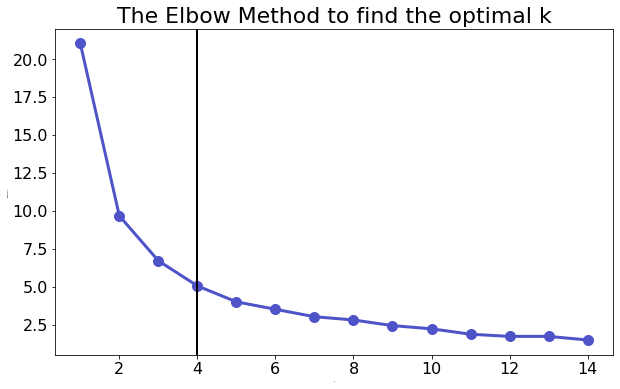

In [18]:
plt.figure(figsize=(10,6))
plt.plot(K, distortions, 'o-', linewidth=3, color='#4e54c8', markersize=10)
plt.xlabel('k', fontsize=2)
plt.ylabel('Distortion', fontsize=2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('The Elbow Method to find the optimal k', fontsize=22)
plt.axvline(x=4, color="black", linewidth=2)
plt.show()

The above plot suggests that 4 clusters is best for our data.

In [19]:
# run k-means clustering
kclusters=4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nearby_venues.drop(['Location', 'Latitude', 'Longitude'], 1))

Add cluster labels to my *nearby_venues* dataframe:

In [20]:
# add clustering labels
nearby_venues.insert(0, 'Cluster', kmeans.labels_)
nearby_venues.head(10)

Category,Cluster,Location,Latitude,Longitude,Coffee,Colleges,Fun,Shopping
0,3,Aldgate,51.513312,-0.077765,0.714286,0.000000,0.461538,0.000
1,0,Aldwych,51.512653,-0.118607,0.795918,1.000000,0.961538,0.625
2,3,Angel,51.524730,-0.087540,0.693878,0.166667,0.769231,0.125
3,2,Bankside,51.508164,-0.095216,0.530612,0.333333,0.346154,0.250
4,3,Barbican,51.520070,-0.093530,0.530612,0.166667,0.653846,0.375
5,1,Barnsbury,51.536489,-0.110907,0.102041,0.000000,0.307692,0.500
6,1,Bayswater,51.510480,-0.184260,0.061224,0.166667,0.115385,0.000
7,1,Belgravia,51.497050,-0.152750,0.142857,0.000000,0.269231,0.500
8,1,Bermondsey,51.497900,-0.081440,0.142857,0.166667,0.076923,0.000
9,1,Bethnal Green,51.524190,-0.059440,0.183673,0.000000,0.153846,0.125


## 4. Results

The above Methodology described how data was obtained for 56 central London Locations and their nearby venues, using Wikipedia and the Foursquare API, and how those locations were clustered based on the type of nearby venues. Here, I'm presenting the results of the location clustering.   

First, I'm re-plotting the London locations, but with each location colour-coded according to its cluster number. I'm using the Stamen Toner map for ease of seeing the cluster colours. Note - click on a location to see its name and cluster number.

In [21]:
# create map
map_clusters = folium.Map(location=[lon_lat, lon_lng],
                          zoom_start=13,
                          tiles='Stamen Toner')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.cool(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, loc, cluster in zip(nearby_venues['Latitude'], nearby_venues['Longitude'], nearby_venues['Location'], nearby_venues['Cluster']):
    label = folium.Popup(str(loc) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Next, I'm plotting the mean frequency of each venue category per cluster in order to compare the distributions:

In [22]:
# mean category frequency per cluster
cluster_means = nearby_venues.groupby('Cluster').mean().drop(['Latitude','Longitude'],1).transpose()
cluster_means

Cluster,0,1,2,3
Category,,,,
Coffee,0.748299,0.136054,0.332810,0.664723
Colleges,0.875000,0.034722,0.397436,0.071429
Fun,0.826923,0.176282,0.417160,0.620879
Shopping,0.583333,0.109375,0.480769,0.125000


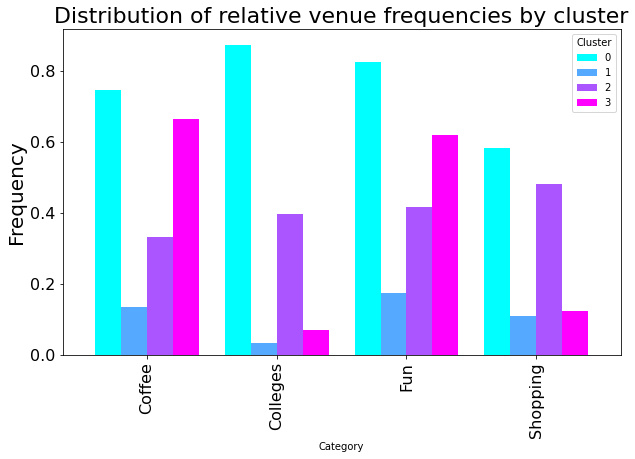

In [23]:
# plot bar graph to compare
cluster_means.plot(kind="bar", figsize=(10,6), 
                   width=0.8, color=rainbow)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Frequency', fontsize=20)
plt.title('Distribution of relative venue frequencies by cluster', fontsize=22)
plt.axhline(y=0, color="black", linewidth=1)
plt.show()

From the above bar graph, it looks like cluster '2' is best cluster to further explore — there aren't too many coffee shops already, and there's also a lot of attractions/shopping and reasonable proximity to student populations, so perhaps there's a good location that we can find. What do the individual locations within this cluster look like?

In [24]:
# dataframe just for cluster '2' locations:
best_cluster = nearby_venues[nearby_venues['Cluster'] == 2]
best_cluster.set_index('Location', inplace=True)
best_cluster

Category,Cluster,Latitude,Longitude,Coffee,Colleges,Fun,Shopping
Location,,,,,,,
Bankside,2,51.508164,-0.095216,0.530612,0.333333,0.346154,0.250
Blackfriars,2,51.511600,-0.102408,0.387755,0.500000,0.500000,0.375
Camden Town,2,51.537899,-0.137591,0.306122,0.833333,0.384615,0.250
Chalk Farm,2,51.542844,-0.148592,0.367347,0.500000,0.346154,0.125
Finsbury,2,51.525908,-0.104334,0.326531,0.333333,0.576923,0.500
Islington,2,51.532790,-0.106140,0.224490,0.333333,0.423077,0.375
King's Cross,2,51.536310,-0.122420,0.346939,0.666667,0.307692,0.625
Knightsbridge,2,51.501867,-0.160329,0.183673,0.166667,0.153846,0.625
Mayfair,2,51.508680,-0.143890,0.346939,0.000000,0.500000,0.875


Here are all of the cluster '2' locations and the frequency of venues within each, sorted by the number of coffee shops they have:

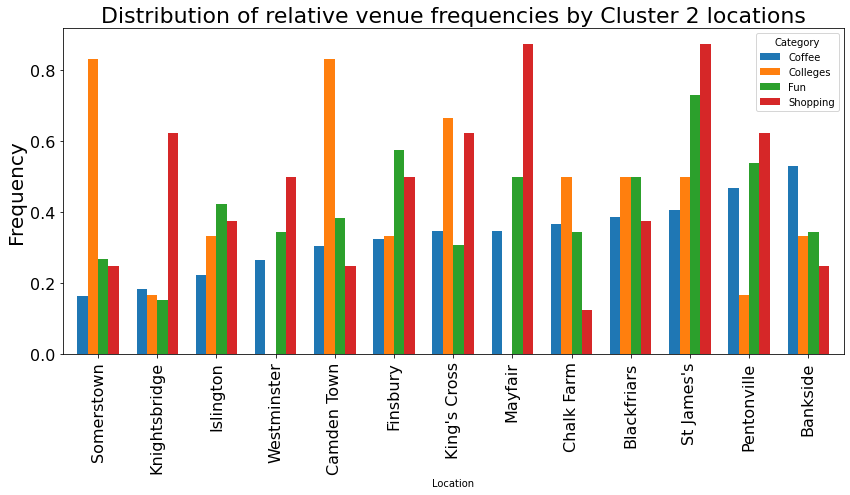

In [25]:
# plot bar graph to compare
best_cluster.drop(['Cluster','Latitude','Longitude'], axis=1).sort_values('Coffee').plot(kind="bar", figsize=(14,6), 
                   width=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Frequency', fontsize=20)
plt.title('Distribution of relative venue frequencies by Cluster 2 locations', fontsize=22)
plt.axhline(y=0, color="black", linewidth=1)
plt.show()

A few possible locations jump out from the above bar graph:  
* Camden Town - not too many coffee shops, some attractions, lots of students
* Kings Cross - not too many coffee shops, near students and shopping
* St. James's - students, and lots of attractions and shopping close by, but 3rd highest coffee shop count in cluster

## 5. Conclusion

Overall, this project aimed to find optimal locations within central London for opening a new coffee shop. To do so, I considered a potentially "good" location as one that had relatively few coffee shops already, but had proximity to a student population as well as attractions and retail.  

Using clustering with Foursquare venue data, I found 4 clusters of London locations, with one particular cluster containing locations that, on average, had relatively few coffee shops already but reasonable proximity to students and entertainment. Within this cluster, 3 possible locations stand out to me as being the best: Camden Town, due to lack of existing competition and lots of students; King's Cross, with limited coffee shops and near to students and shopping; St James's, which has some students and lots of attractions close by.

Of course, other factors would need to be considered in order to fully specify the best location (e.g. unit availability, rent, and other overheads). Also, understanding the nearby residential population would be helpful. 